# Example of prediction of financial effect from model 

In [1]:
import warnings
from typing import Union, Iterable

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from hypex import AATest, ABTest
from hypex.utils.tutorial_data_creation import create_test_data

pd.options.display.float_format = "{:,.2f}".format

np.random.seed(42)  # needed to create example data

## 0. Example of researchable model

In [2]:
class RandomModel:
    def __init__(
            self,
            target_field: str,
            group_fields: Union[str, Iterable[str]] = None,
            diff_percentage: float = 0.01,
            sd_percentage: float = 0.1,
    ):
        self.target_field = target_field
        self.group_fields = group_fields
        self.diff_percentage = diff_percentage
        self.sd_percentage = sd_percentage

        self.params = {None: {}}

    def fill_na(self, data: pd.DataFrame):
        t_data = data.copy()
        t_data[self.group_fields] = t_data[self.group_fields].fillna("None")
        return t_data

    def fit(self, data: pd.DataFrame):
        t_data = self.fill_na(data)
        self.params["None"] = {
            "mean": t_data[self.target_field].mean(),
            "sd": t_data[self.target_field].std(),
        }
        if self.group_fields is not None:
            for group, group_data in t_data.groupby(self.group_fields):
                self.params[group] = {
                    "mean": group_data[self.target_field].mean(),
                    "sd": group_data[self.target_field].std(),
                }

        return self

    def predict(self, data: pd.DataFrame):
        t_data = self.fill_na(data)

        result = pd.concat(
            [
                pd.Series(
                    index=group_data.index,
                    data=np.random.normal(
                        self.params.get(group, self.params["None"])["mean"]
                        * self.diff_percentage,
                        self.params.get(group, self.params["None"])["sd"]
                        * self.sd_percentage,
                        len(group_data),
                    ),
                )
                for group, group_data in t_data.groupby(self.group_fields)
            ]
        )
        return t_data[self.target_field] + result

## 1. Data creation 

In this case we will create random dataset with known effect size
If you have your own dataset, go to the part 2

In [3]:
data = create_test_data(rs=52, na_step=10, nan_cols=["age", "gender"])
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry
0,0,0,0,488.00,414.44,NaN,M,E-commerce
1,1,8,1,512.50,462.22,26.00,NaN,E-commerce
2,2,7,1,483.00,479.44,25.00,M,Logistics
3,3,0,0,501.50,424.33,39.00,M,E-commerce
4,4,1,1,543.00,514.56,18.00,F,E-commerce
...,...,...,...,...,...,...,...,...
9995,9995,10,1,538.50,450.44,42.00,M,Logistics
9996,9996,0,0,500.50,430.89,26.00,F,Logistics
9997,9997,3,1,473.00,534.11,22.00,F,E-commerce
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce


# 2. Fit and estimate random model

In [4]:
model = RandomModel(
    target_field="post_spends",
    group_fields=["age", "gender", "industry"],
    diff_percentage=0.1,
    sd_percentage=1
)
model = model.fit(data)
data["corrected_spends"] = model.predict(data)
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,corrected_spends
0,0,0,0,488.00,414.44,NaN,M,E-commerce,418.83
1,1,8,1,512.50,462.22,26.00,NaN,E-commerce,469.73
2,2,7,1,483.00,479.44,25.00,M,Logistics,536.16
3,3,0,0,501.50,424.33,39.00,M,E-commerce,451.99
4,4,1,1,543.00,514.56,18.00,F,E-commerce,523.02
...,...,...,...,...,...,...,...,...,...
9995,9995,10,1,538.50,450.44,42.00,M,Logistics,458.44
9996,9996,0,0,500.50,430.89,26.00,F,Logistics,502.74
9997,9997,3,1,473.00,534.11,22.00,F,E-commerce,537.17
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce,475.78


Data preprocessing. 


In [5]:
data["age is missing"] = data["age"].isna() * 1
data["gender"] = data["gender"].fillna("None")
data["age"] = data["age"].fillna(int(data["age"].mean()))
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,corrected_spends,age is missing
0,0,0,0,488.00,414.44,43.00,M,E-commerce,418.83,1
1,1,8,1,512.50,462.22,26.00,None,E-commerce,469.73,0
2,2,7,1,483.00,479.44,25.00,M,Logistics,536.16,0
3,3,0,0,501.50,424.33,39.00,M,E-commerce,451.99,0
4,4,1,1,543.00,514.56,18.00,F,E-commerce,523.02,0
...,...,...,...,...,...,...,...,...,...,...
9995,9995,10,1,538.50,450.44,42.00,M,Logistics,458.44,0
9996,9996,0,0,500.50,430.89,26.00,F,Logistics,502.74,0
9997,9997,3,1,473.00,534.11,22.00,F,E-commerce,537.17,0
9998,9998,2,1,495.00,523.22,67.00,F,E-commerce,475.78,0


# 3. AA-test estimation

Group optimization:   0%|          | 0/3 [00:00<?, ?it/s]

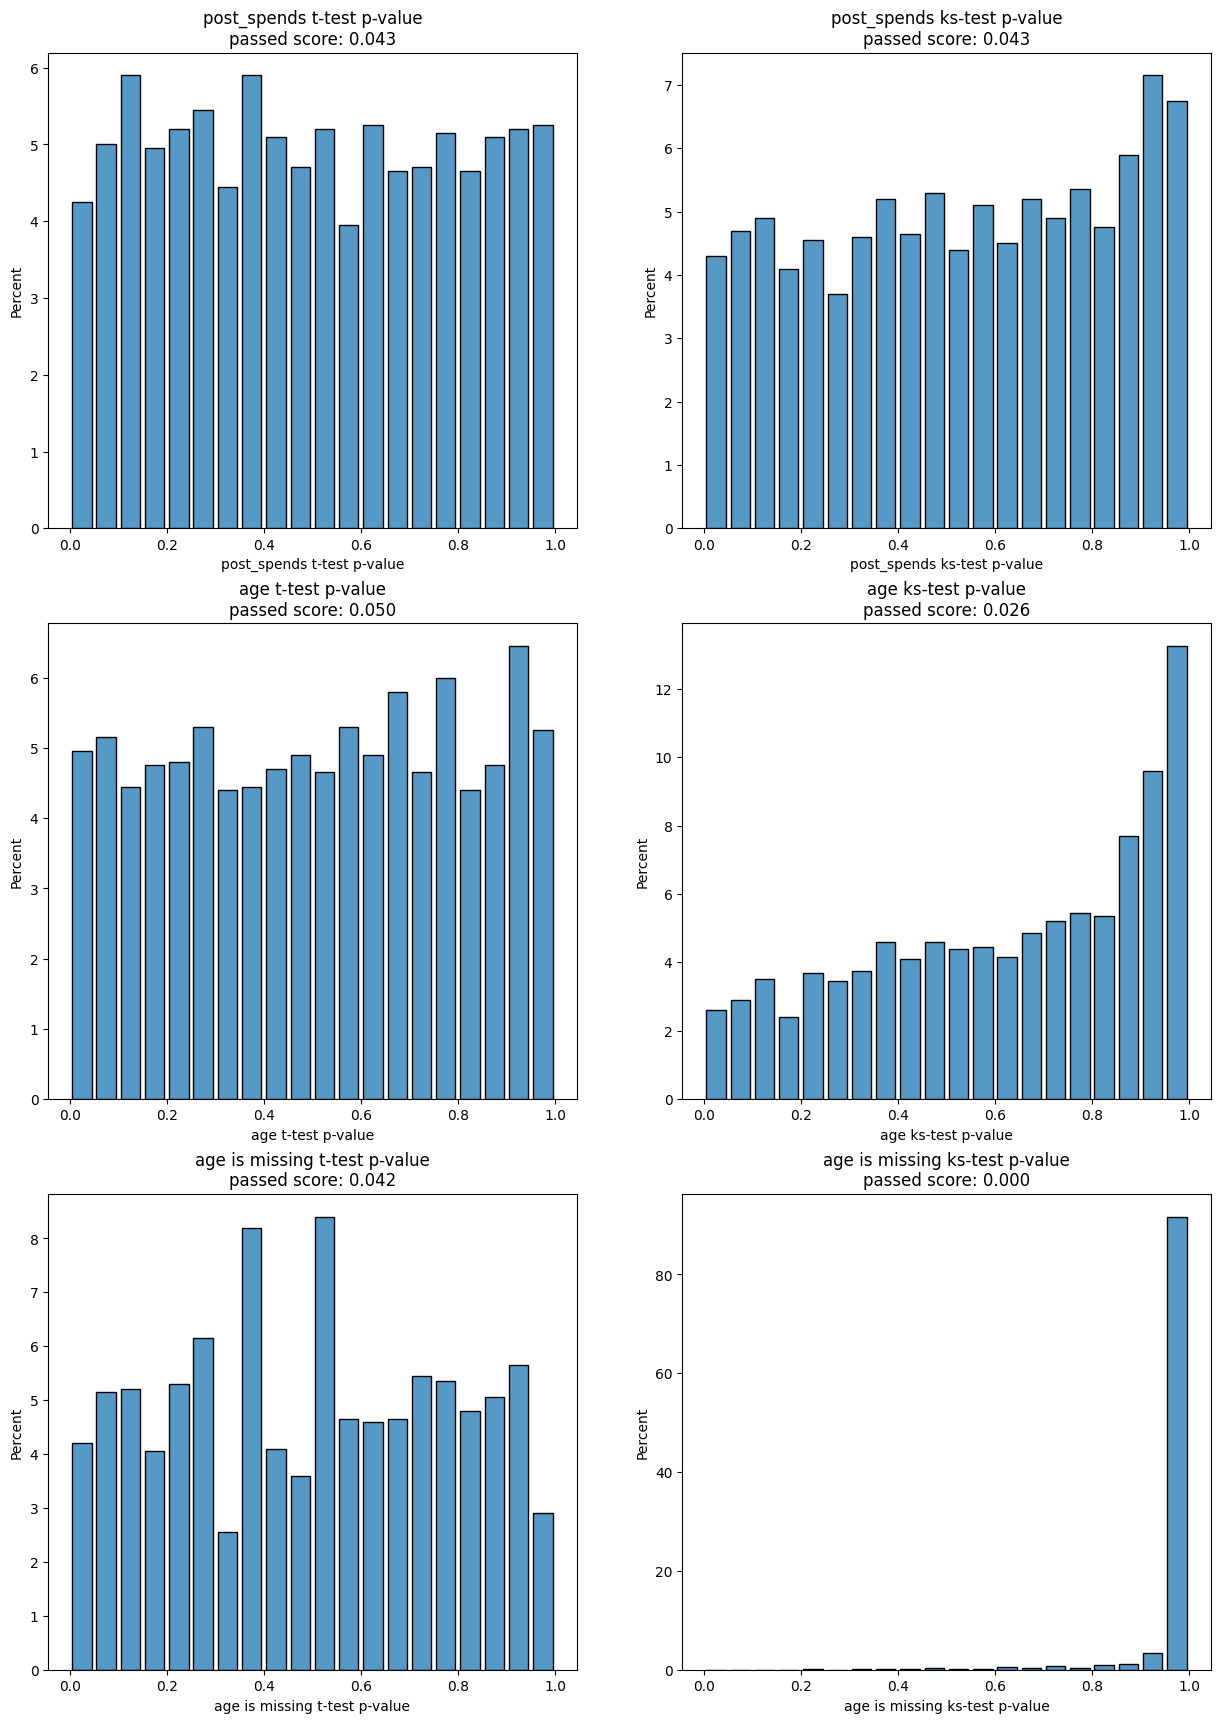

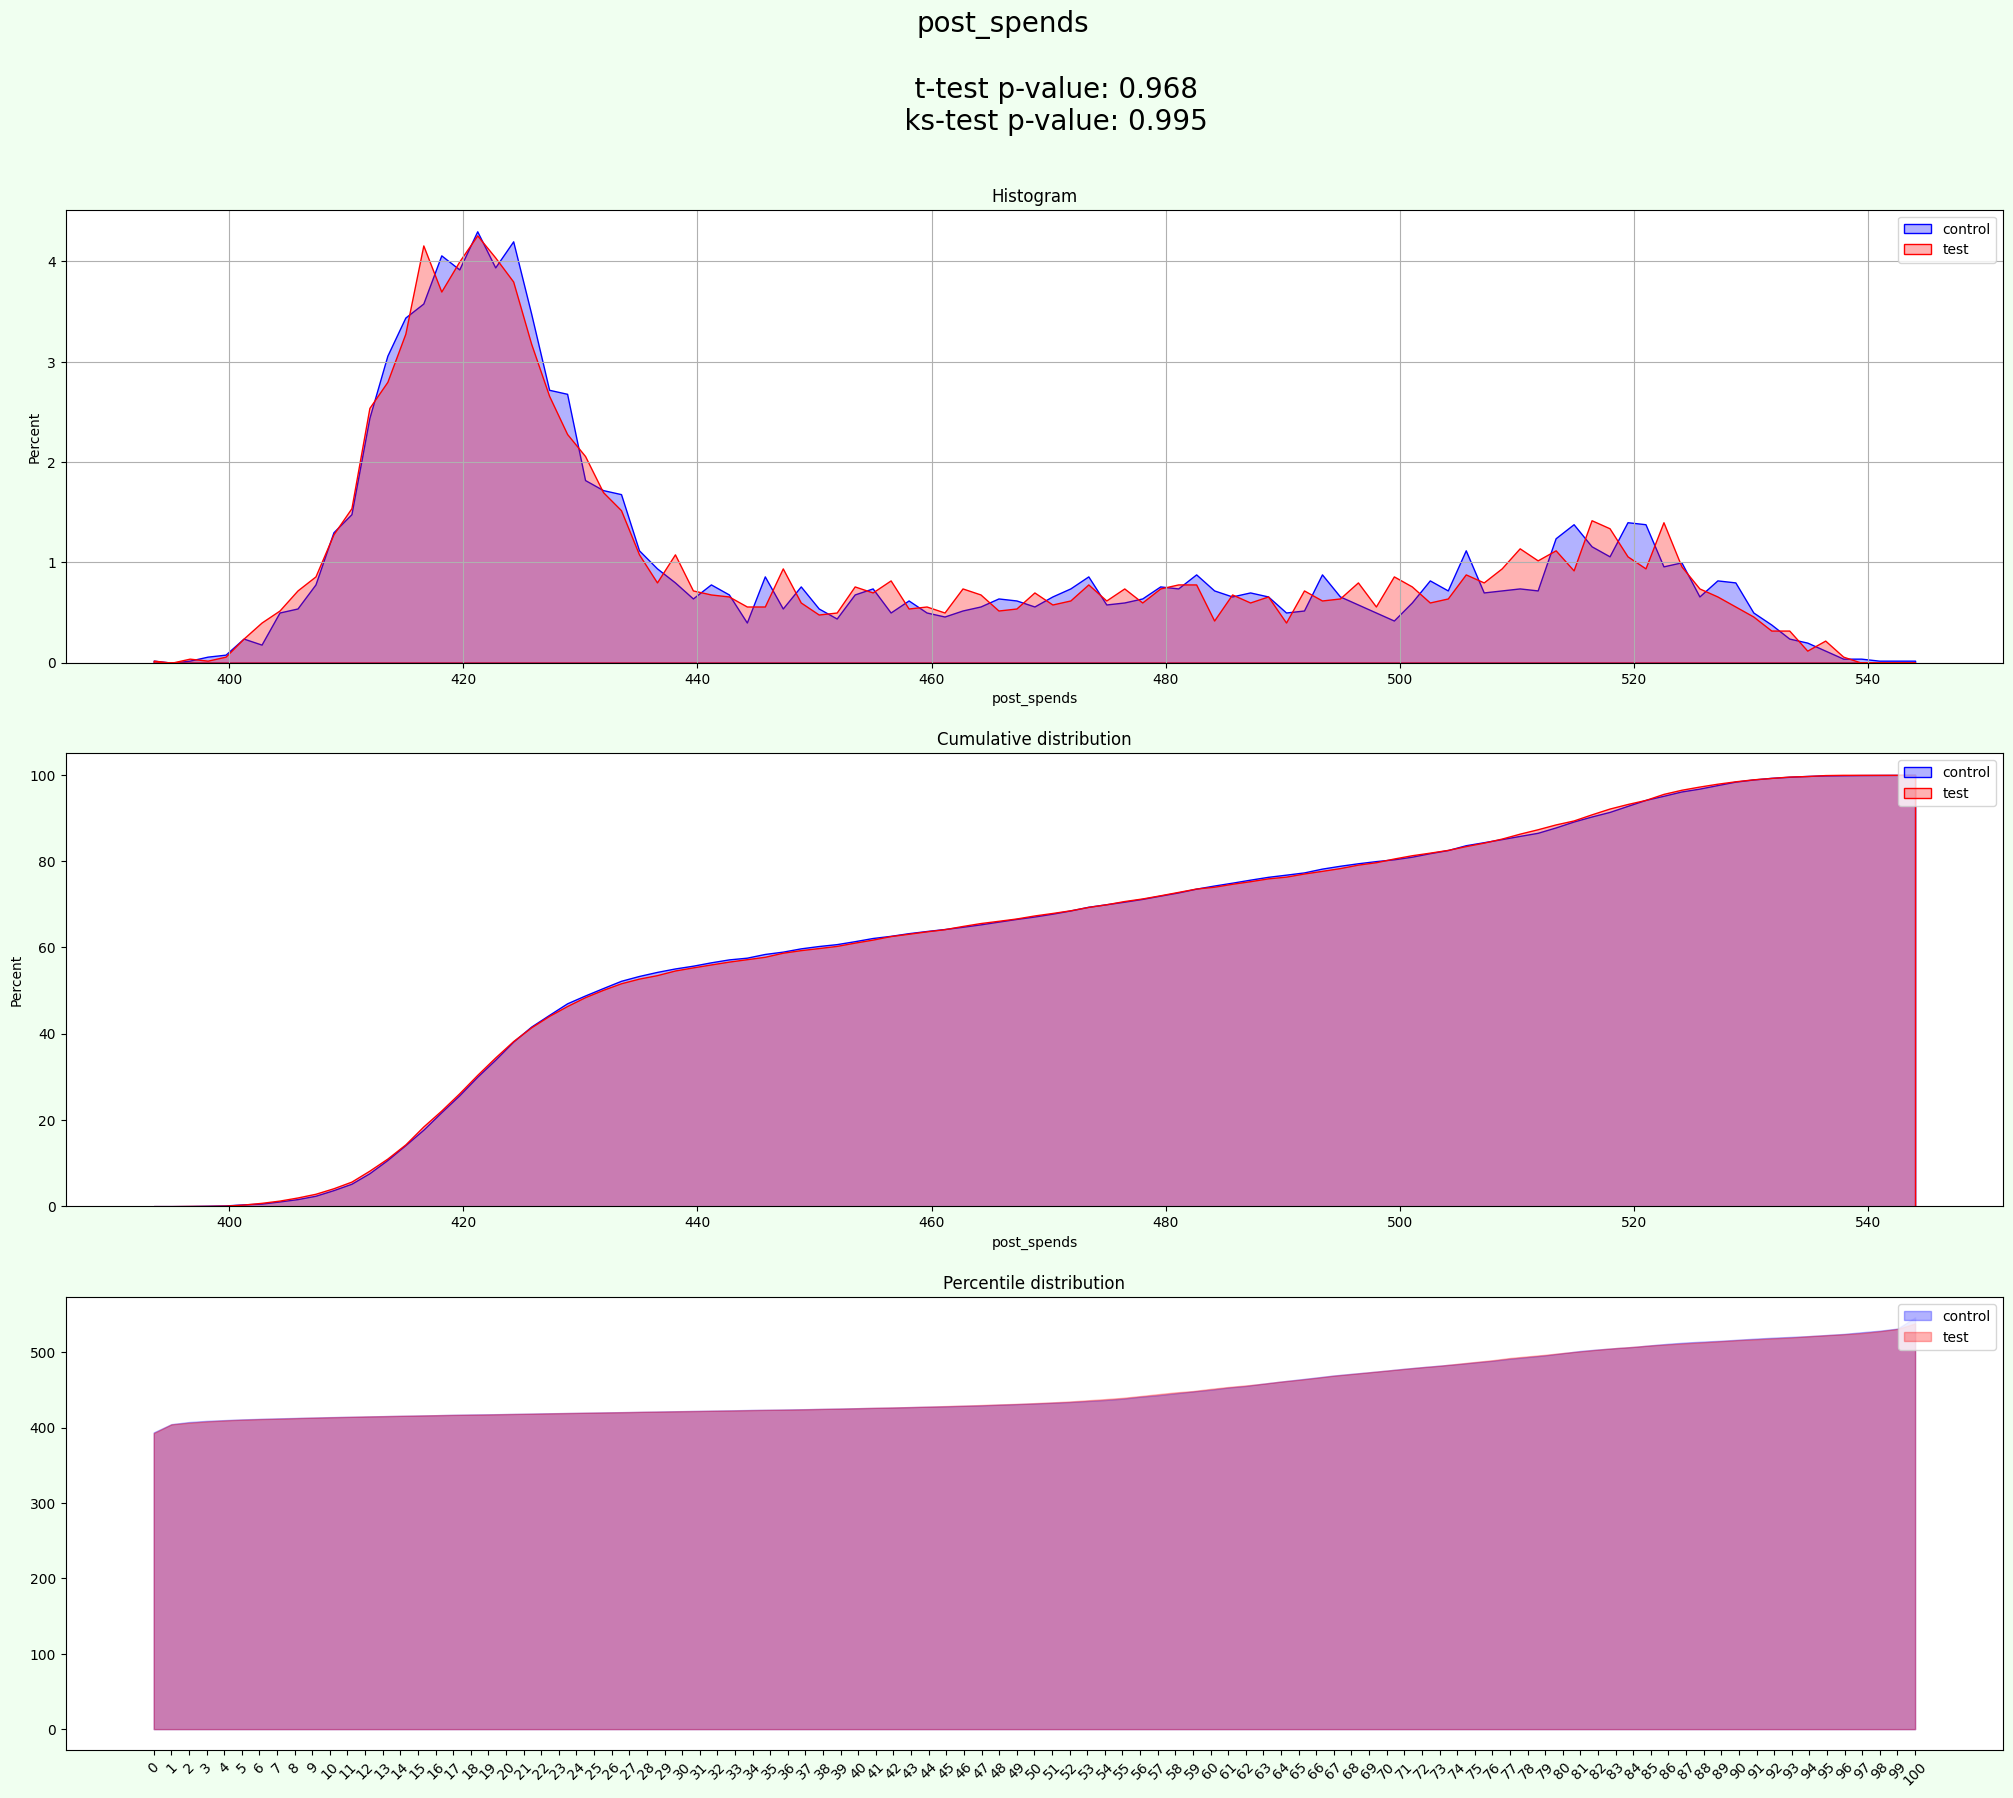

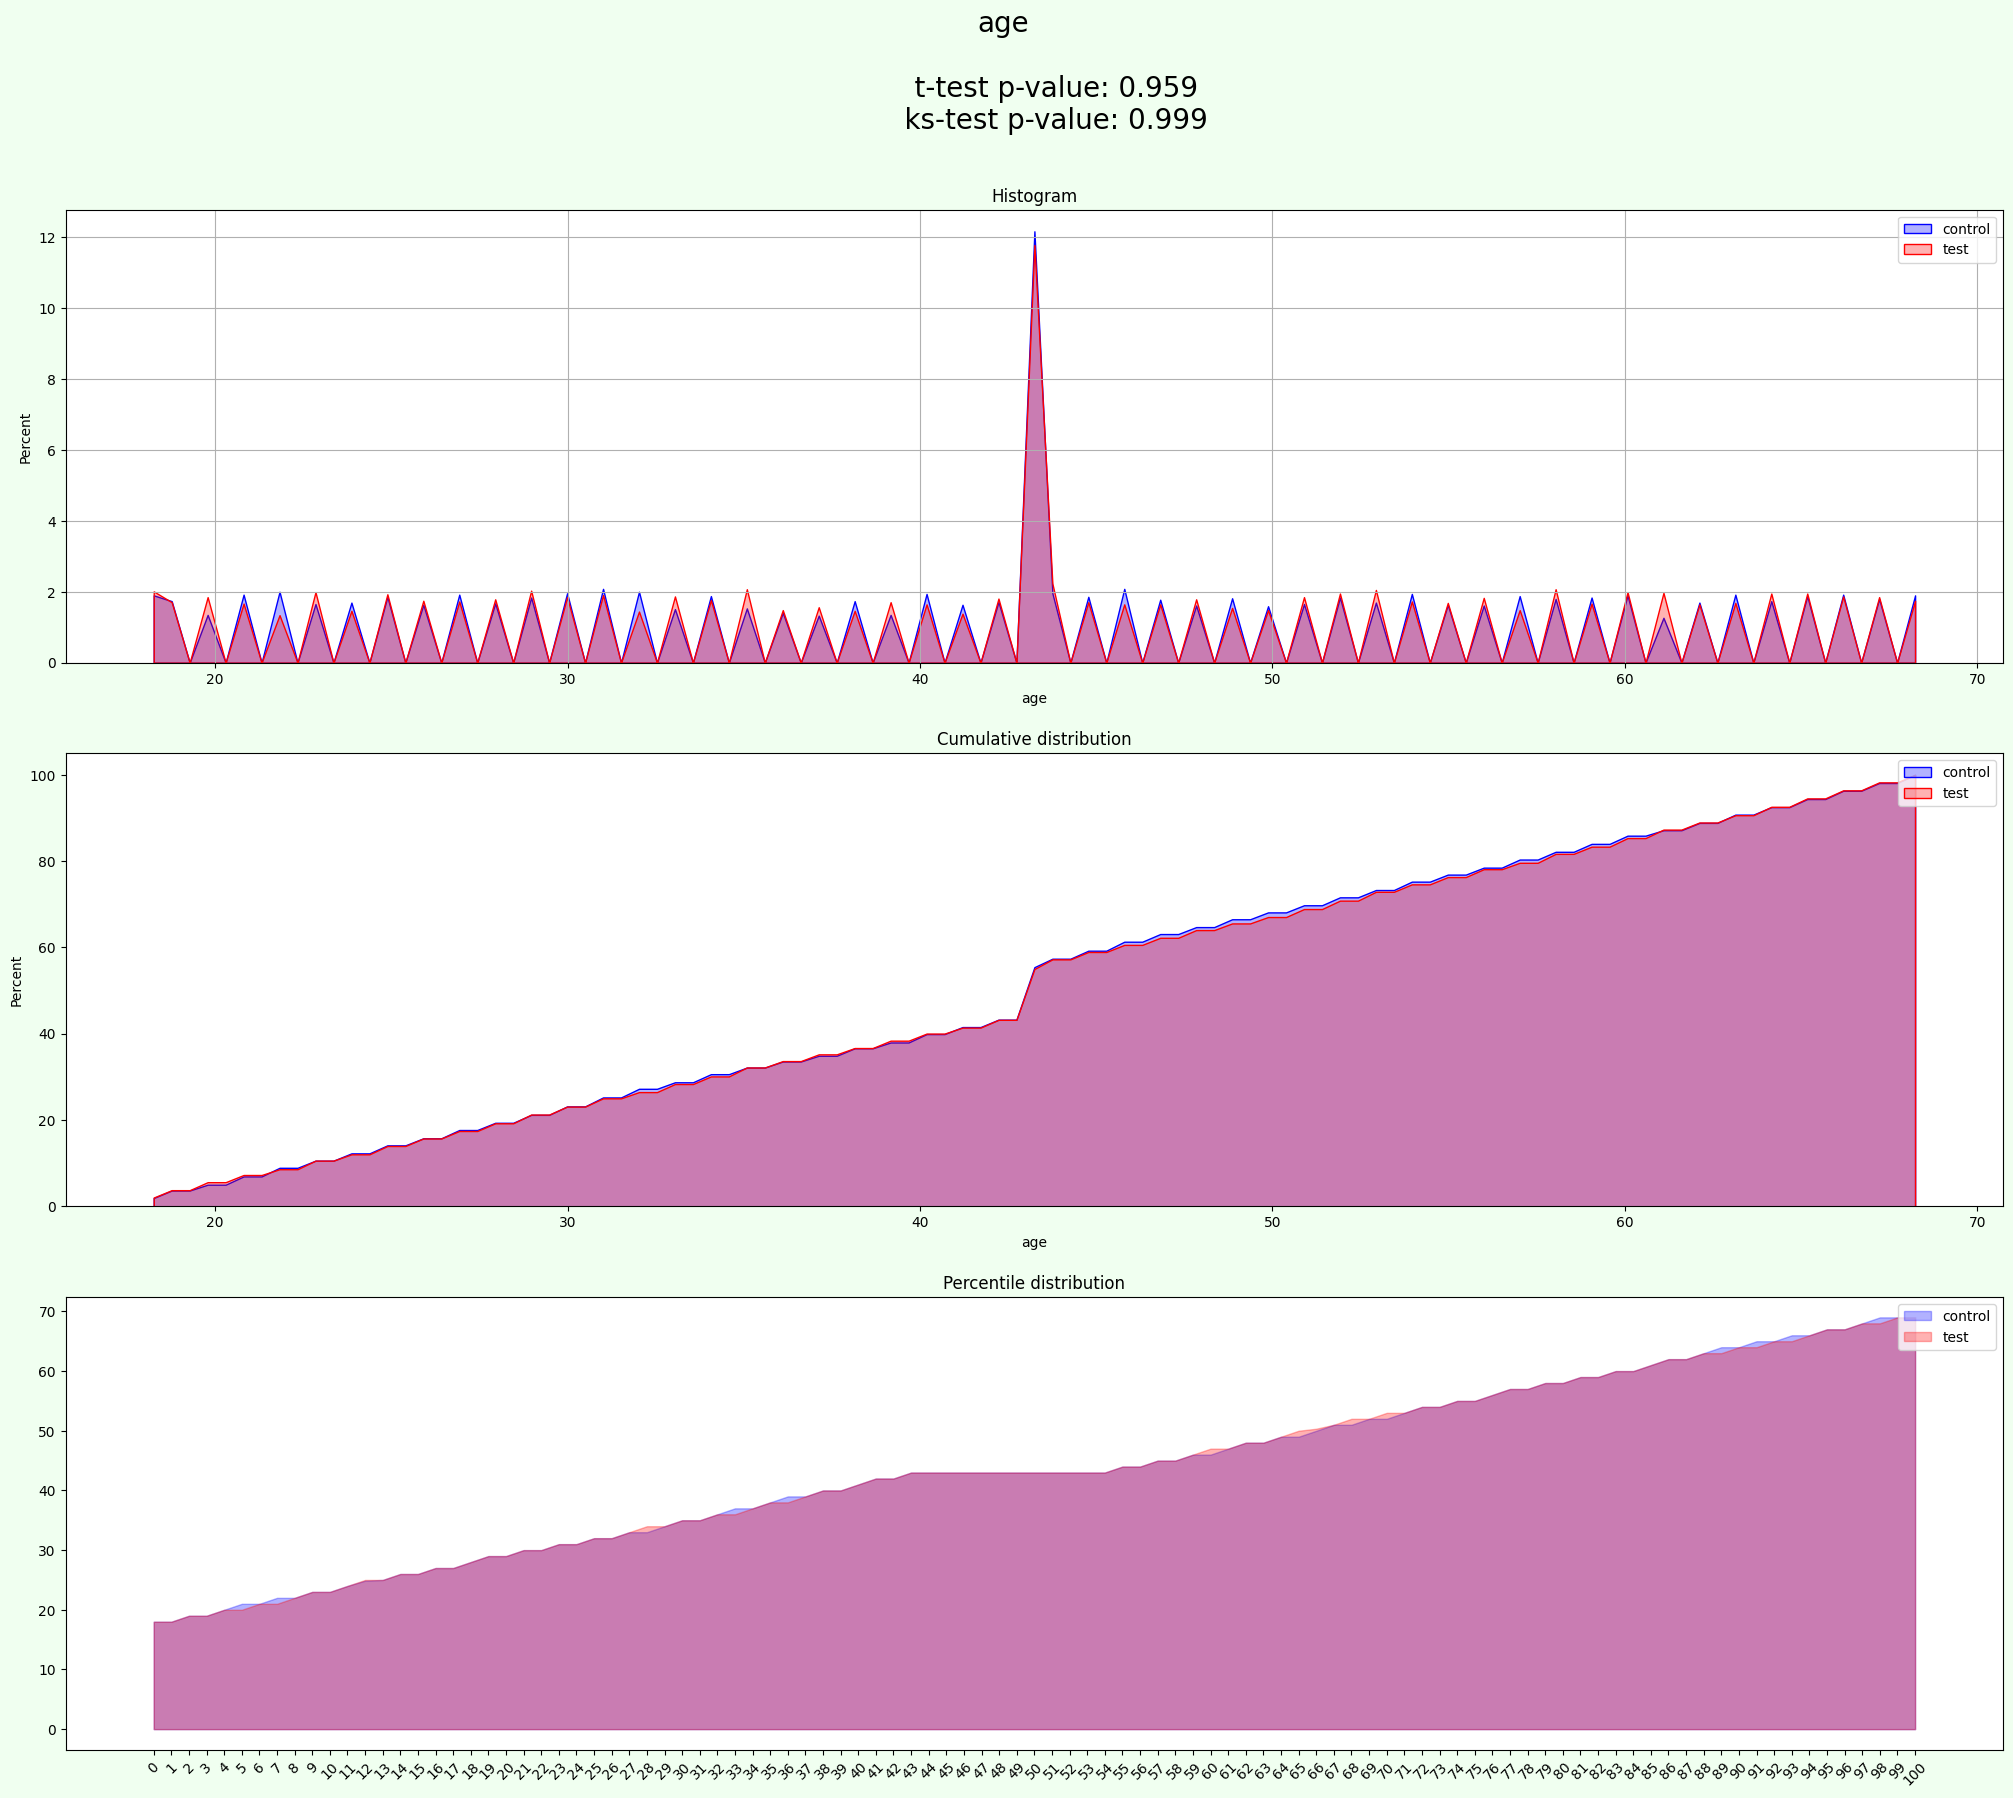

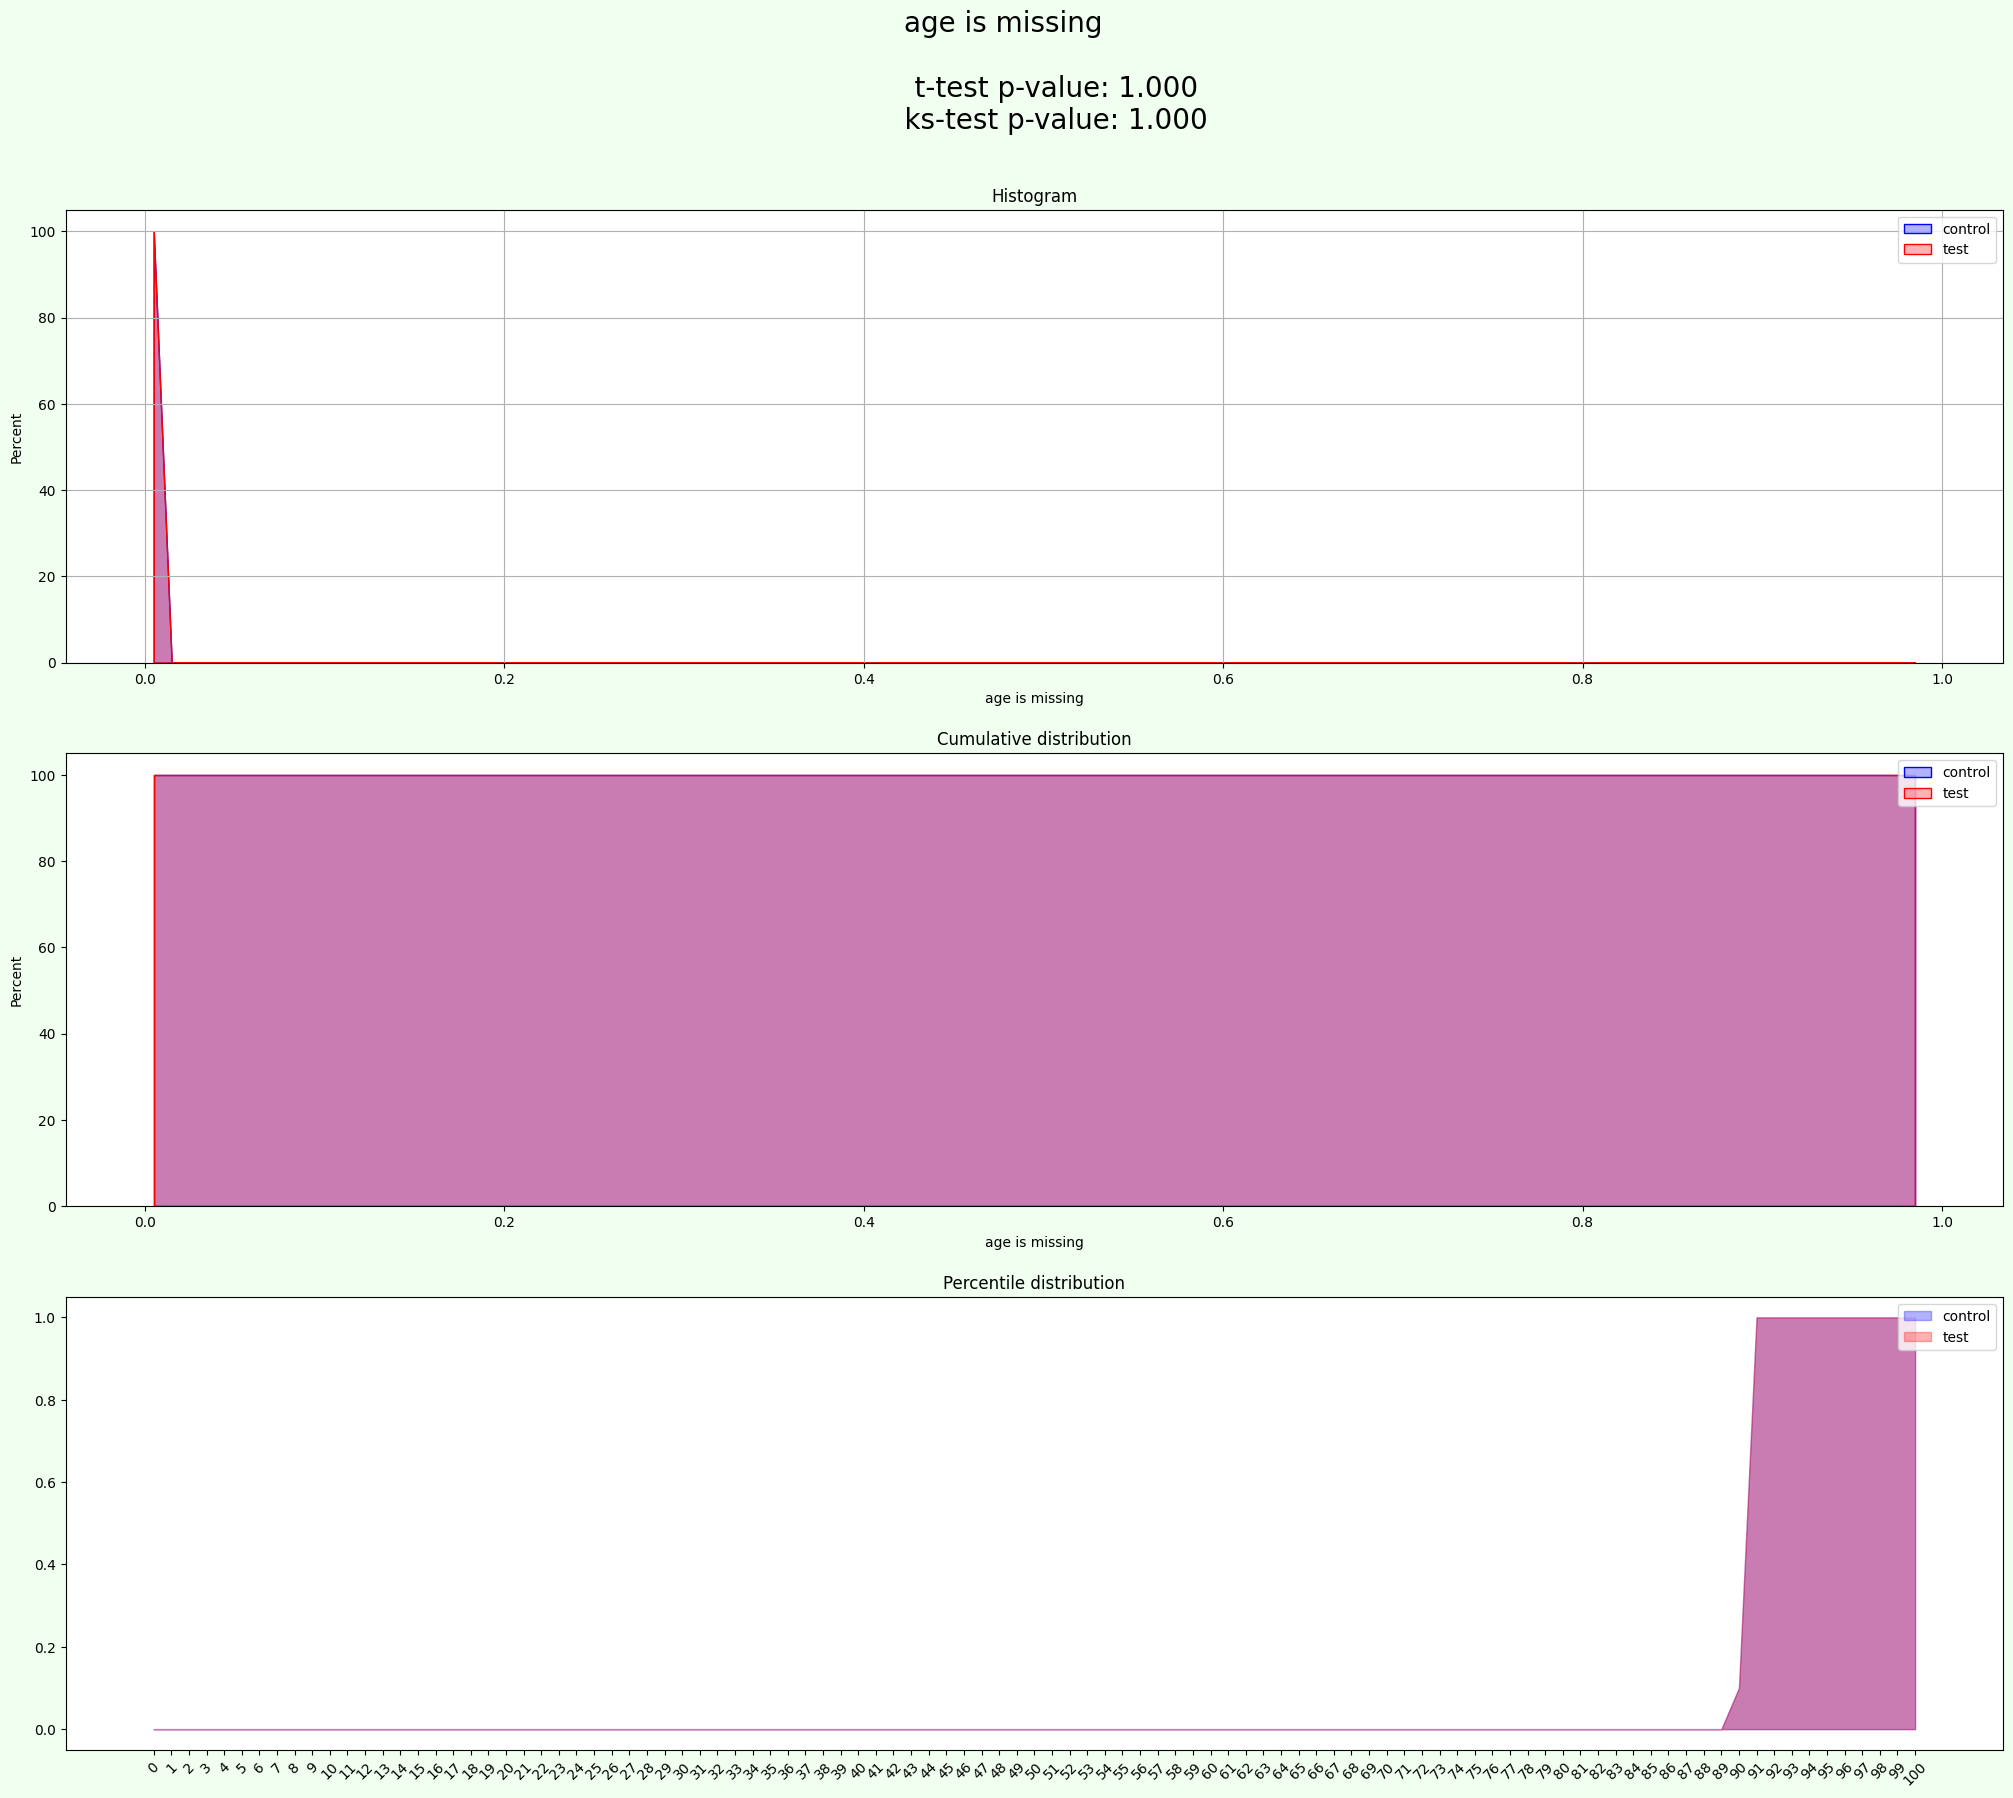

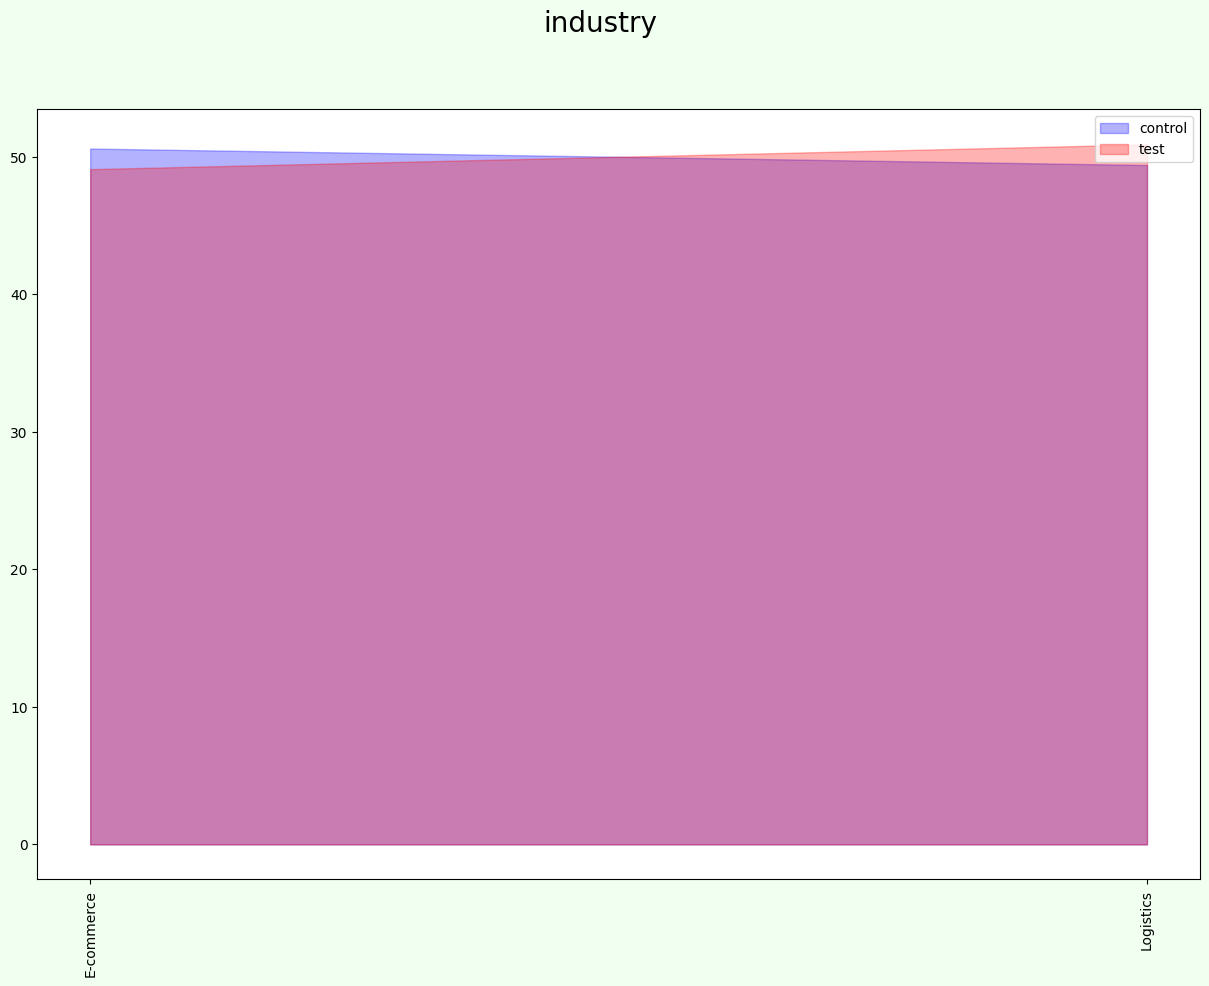

In [6]:
aa_test = AATest(
    target_fields=["post_spends", "age", "age is missing"], info_cols="user_id"
)
result = aa_test.process(data, show_plots=True, optimize_groups=True)

Barplots check uniformity of distribution of p-value in statistics tests.
Plots show homogeneity of distributions between values in A and B groups. 

Read more about AATest [here](https://github.com/sb-ai-lab/HypEx/blob/feature/experiments/examples/tutorials/Tutorial_2_AAtesting.ipynb ).

In [7]:
result["resume"]

,aa test passed,split is uniform
post_spends,OK,OK
age,OK,OK
age is missing,OK,OK


Dependes on group, test or control, choose target value and add new column "researched field". If group is test, add predicted value. 

In [8]:
splited_data = result["split"]
splited_data["researched field"] = splited_data.apply(
    lambda x: x["corrected_spends"] if x["group"] == "test" else x["post_spends"],
    axis=1,
)
splited_data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,corrected_spends,age is missing,group,researched field
0,0,0,0,488.00,414.44,43.00,M,E-commerce,418.83,1,test,418.83
1,3,0,0,501.50,424.33,39.00,M,E-commerce,451.99,0,test,451.99
2,5,6,1,486.50,486.56,44.00,M,E-commerce,512.53,0,test,512.53
3,6,11,1,483.50,433.89,28.00,F,Logistics,588.87,0,test,588.87
4,11,4,1,498.50,516.89,58.00,None,E-commerce,628.31,0,test,628.31
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9990,0,0,490.00,426.00,43.00,M,Logistics,507.05,1,control,426.00
9996,9993,5,1,462.00,509.89,65.00,F,E-commerce,622.51,0,control,509.89
9997,9996,0,0,500.50,430.89,26.00,F,Logistics,502.74,0,control,430.89
9998,9997,3,1,473.00,534.11,22.00,F,E-commerce,537.17,0,control,534.11


## 4. Performing AB-test on "researched field" 

Read more about ABTest [here](https://github.com/sb-ai-lab/HypEx/blob/feature/experiments/examples/tutorials/Tutorial_3_ABtesting.ipynb ).

In [9]:
ab_test = ABTest(calc_difference_method="ate", calc_p_value_method="t-test")
ab_result = ab_test.execute(
    splited_data, target_field="researched field", group_field="group"
)
ab_result

{'size': {'test': 5000, 'control': 5000},
 'difference': {'ate': 45.24911471331357},
 'p-value': {'t-test': 0.0}}